# 🧠 D&D Monster Analytics: Fase 3 - Model Training & Evaluation

**Obiettivo:** Addestrare, confrontare e analizzare diversi modelli di Machine Learning per predire il Challenge Rating (CR).

### 📋 Requisiti del Progetto Soddisfatti:
1.  **Model Selection:** Confronto tra Linear Regression (Baseline), Random Forest e Gradient Boosting.
2.  **Performance:** Valutazione con metriche standard (MAE, RMSE, R2).
3.  **Error Analysis:** Studio dei residui e degli errori di predizione.

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Configurazione Plot
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
print("✅ Librerie caricate.")

✅ Librerie caricate.


## 1. Caricamento e Split dei Dati
Carichiamo il dataset pulito `monsters_final_clean.csv`. 
Separiamo le feature (X) dal target (y) e creiamo i set di Training (80%) e Test (20%).

In [20]:
# Caricamento
df = pd.read_csv("./data/monsters_final.csv")
print(f"✅ Dataset caricato: {df.shape}")

# Preprocessing al volo
if 'name' in df.columns:
    df = df.drop(columns=['name']) # Rimuoviamo l'identificativo

# Definizione X e y
target = 'cr'
X = df.drop(columns=[target])
y = df[target]

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"🔹 Training Set: {X_train.shape[0]} righe")
print(f"🔸 Test Set: {X_test.shape[0]} righe")

✅ Dataset caricato: (2435, 73)
🔹 Training Set: 1948 righe
🔸 Test Set: 487 righe


## 2. Model Selection & Training
Addestriamo tre modelli diversi per giustificare la scelta finale:
1.  **Linear Regression:** Modello semplice e interpretabile. Serve da *baseline*: se un modello complesso fa peggio di questo, non vale la pena usarlo.
2.  **Random Forest:** Modello a ensemble (bagging). Gestisce benissimo le non-linearità e gli outlier.
3.  **Gradient Boosting:** Modello a ensemble (boosting). Spesso offre la massima precisione riducendo il bias.

In [21]:
# Dizionario dei modelli
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42)
}

# Dizionario per salvare i risultati
results = {}
predictions = {}

print("🚀 Inizio Addestramento...")
for name, model in models.items():
    # Train
    model.fit(X_train, y_train)
    # Predict
    pred = model.predict(X_test)
    predictions[name] = pred
    
    # Evaluate
    mae = mean_absolute_error(y_test, pred)
    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)
    
    results[name] = {"MAE": mae, "RMSE": rmse, "R2": r2}
    print(f"✅ {name} completato.")

🚀 Inizio Addestramento...
✅ Linear Regression completato.
✅ Random Forest completato.
✅ Gradient Boosting completato.


## 3. Confronto delle Performance
Visualizziamo i risultati in una tabella e un grafico.

                        MAE      RMSE        R2
Linear Regression  1.109631  1.487320  0.916808
Random Forest      0.815116  1.194633  0.946329
Gradient Boosting  0.804705  1.170305  0.948492


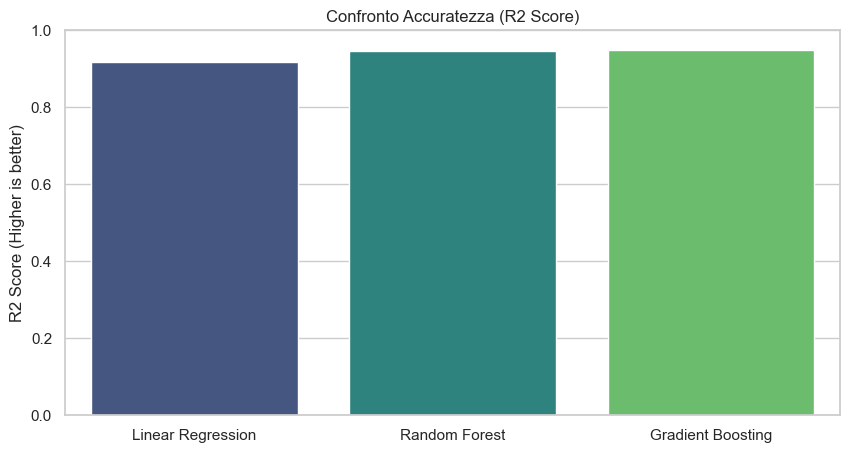

In [22]:
# Creazione DataFrame Risultati
res_df = pd.DataFrame(results).T
print(res_df)

# Plot R2 Score Comparison
plt.figure(figsize=(10, 5))
sns.barplot(x=res_df.index, y=res_df['R2'], hue=res_df.index, palette="viridis", legend=False)
plt.title('Confronto Accuratezza (R2 Score)')
plt.ylim(0, 1)
plt.ylabel('R2 Score (Higher is better)')
plt.xlabel(" ")
plt.show()

## 4. Analisi degli Errori (Deep Dive)
Analizziamo il modello migliore (presumibilmente Random Forest o Gradient Boosting) per capire **dove** sbaglia.

### Grafico: Predetto vs Reale
Se il modello fosse perfetto, tutti i punti starebbero sulla linea rossa tratteggiata.

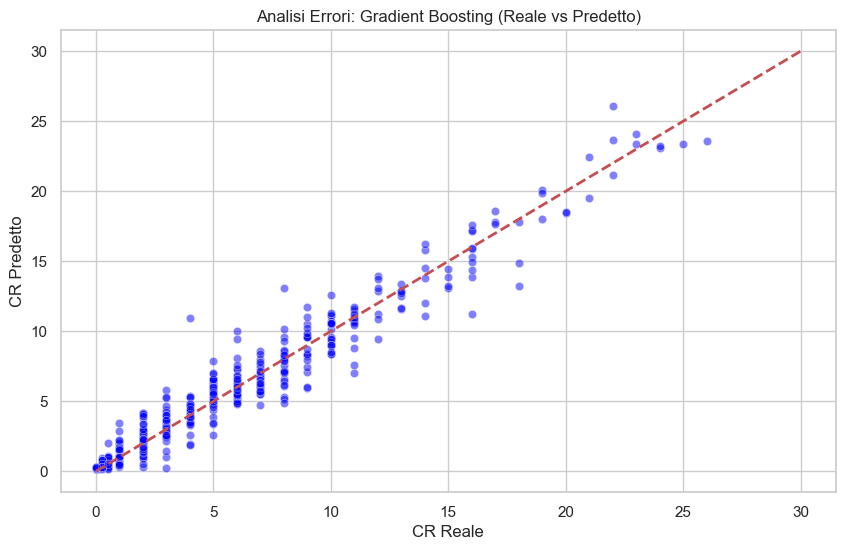

In [23]:
# Selezioniamo il miglior modello (basato su R2)
best_model_name = res_df['R2'].idxmax()
best_pred = predictions[best_model_name]

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=best_pred, alpha=0.5, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], '--r', linewidth=2)
plt.title(f'Analisi Errori: {best_model_name} (Reale vs Predetto)')
plt.xlabel('CR Reale')
plt.ylabel('CR Predetto')
plt.show()

### Analisi dei Residui
I residui sono la differenza tra `Reale - Predetto`.
* **Distribuzione Normale (Campana):** Se i residui formano una campana centrata su 0, il modello è sano.
* **Bias:** Se la campana è spostata, il modello sovrastima o sottostima sistematicamente.

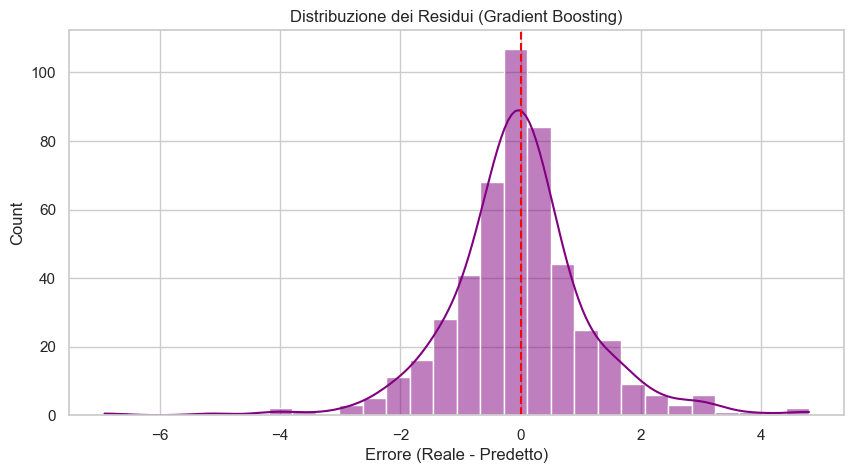

In [24]:
residuals = y_test - best_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple', bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.title(f'Distribuzione dei Residui ({best_model_name})')
plt.xlabel('Errore (Reale - Predetto)')
plt.show()

## 5. Feature Importance
Quali statistiche influenzano di più il CR? Questa è la "spiegabilità" del modello.

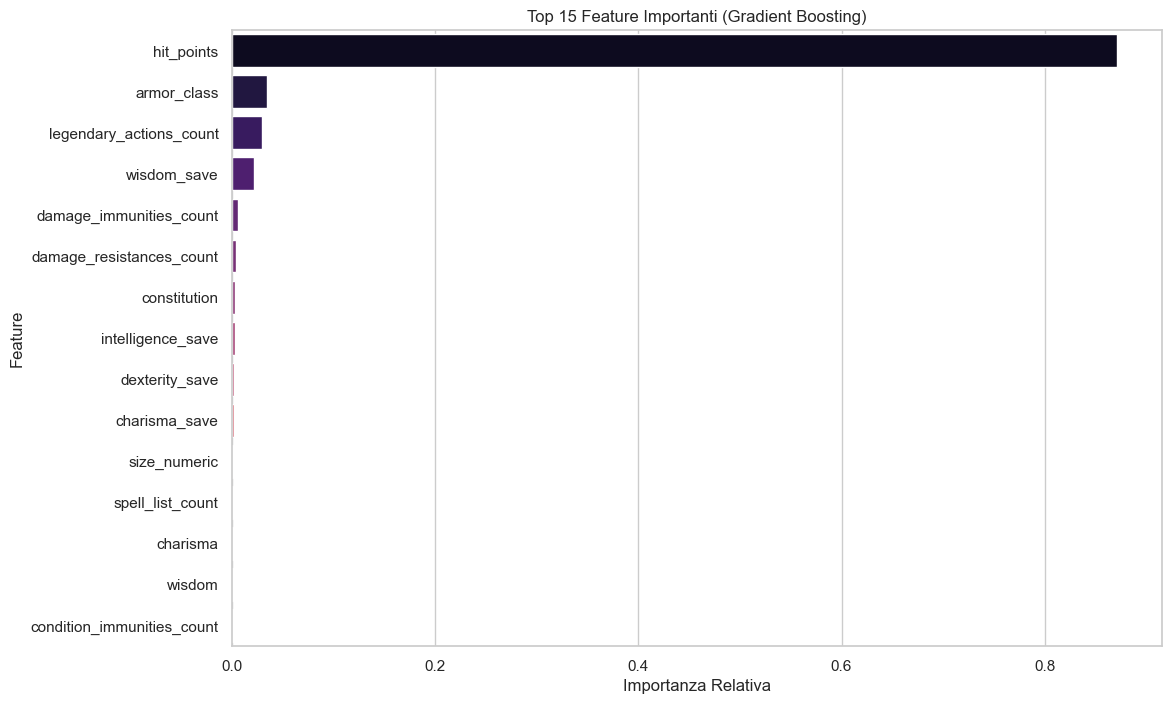

In [28]:
# Estrazione Feature Importance (funziona per RF e GB)
model_obj = models[best_model_name]

if hasattr(model_obj, 'feature_importances_'):
    importances = model_obj.feature_importances_
    feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
    feat_df = feat_df.sort_values(by='Importance', ascending=False).head(15)

    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', hue='Feature', data=feat_df, palette='magma')
    plt.title(f'Top 15 Feature Importanti ({best_model_name})')
    plt.xlabel('Importanza Relativa')
    plt.show()
else:
    print("Il modello selezionato non supporta feature_importances_ standard.")